# DeepGaze II and ICF

This notebook demonstrates how to load and use the DeepGaze II and ICF models.
It needs
to be run using python3 and an up to date tensor flow installation (I use
tensorflow 1.1, but tensorflow 1.0 might work, too). Using a GPU will
considerably speed up computation.

DeepGaze expects it's input to have a resolution of 35 pixel per degree of visual angle. If your stimuli have a different resolution, you have to rescale them before processing them with DeepGaze, otherwise you will get wrong predictions.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.ndimage import zoom
from scipy.misc import logsumexp

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns
sns.set_style('white')

In [3]:
import tensorflow as tf

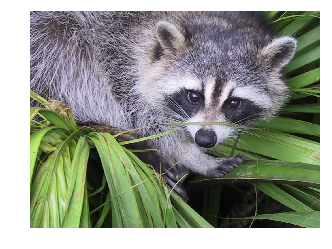

In [4]:
# our example image for which we will calculate DeepGaze predictions

from scipy.misc import face
img = face()

plt.imshow(img)
plt.axis('off');

DeepGaze II and ICF incorporate a center bias as a prior over the fixation distribution. Here we are going to use the center bias from the MIT1003 dataset (see notebook `Centerbias.ipynb`). You should use the best centerbias you can come up with for your dataset.

In [5]:
# load precomputed log density over a 1024x1024 image
centerbias_template = np.load('centerbias.npy')  
# rescale to match image size
centerbias = zoom(centerbias_template, (img.shape[0]/1024, img.shape[1]/1024), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

The model expects all input as 4d tensors of shape `BHWC` (i.e. batch-height-
width-channel). It takes two inputs:
A batch of images and a batch of centerbias log densities.

In [6]:
image_data = img[np.newaxis, :, :, :]  # BHWC, three channels (RGB)
centerbias_data = centerbias[np.newaxis, :, :, np.newaxis]  # BHWC, 1 channel (log density)

Now we import the deep gaze model from the tensorflow meta-graph file

In [7]:
tf.reset_default_graph()

In [8]:
check_point = 'DeepGazeII.ckpt'  # DeepGaze II
#check_point = 'ICF.ckpt'  # ICF
new_saver = tf.train.import_meta_graph('{}.meta'.format(check_point))

input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

And finally we create a tensorflow session, restore the model parameters from
the checkpoint and compute the log density prediction for out input data:

In [9]:
with tf.Session() as sess:
    
    new_saver.restore(sess, check_point)
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

INFO:tensorflow:Restoring parameters from DeepGazeII.ckpt


The log density predictions again are of shape `BHWC`. Since the log-densities
are just 2d, `C=1`. And since we processed only one image, `B=1`:

In [10]:
print(log_density_prediction.shape)

(1, 768, 1024, 1)


Finally, we can visualize the model prediction. This is how the log density
looks like:

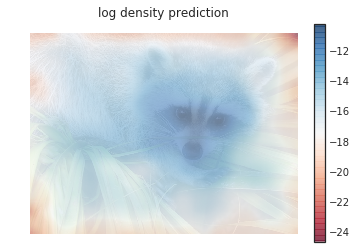

In [11]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');

And this is how the corresponding density looks like

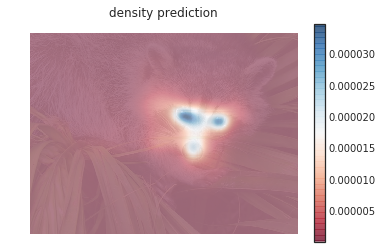

In [12]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow(np.exp(log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('density prediction')
plt.axis('off');

For converting these predictions into saliency maps for the different saliency metrics (AUC, sAUC, CC, SIM, ...), have a look at *Kümmerer et. al: Saliency Benchmarking: Separating Moldels, Maps and Metrics.* [ArXiV 1704.08615](https://arxiv.org/abs/1704.08615)